# Análisis de Clustering de Sujetos

Este notebook evalúa si existen subpoblaciones naturales entre los 78 sujetos del dataset Sleep-EDF,
basándose en sus perfiles de features de sueño.

## Objetivo

Determinar si los sujetos forman **clusters discretos** o un **espectro continuo**, utilizando
múltiples métricas de validación de clustering.

## Metodología

1. Agregación de 133 features a nivel sujeto (media de todos los epochs)
2. Normalización (StandardScaler)
3. Evaluación de tendencia a clustering (Hopkins statistic)
4. Clustering jerárquico (Ward) con múltiples valores de K
5. Validación: Silhouette, Calinski-Harabasz, Davies-Bouldin, Gap statistic
6. Permutation test para significancia estadística

In [17]:
import json
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.manifold import TSNE
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_samples,
    silhouette_score,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

# Paths
PROJECT_ROOT = Path(".").resolve().parent
FEATURES_PATH = PROJECT_ROOT / "data/processed/features_resamp200.parquet"
OUTPUT_DIR = PROJECT_ROOT / "reports/clustering"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")

Project root: /Users/ignacio/Repos/sleep-ST


## 1. Carga y Preparación de Datos

In [18]:
# Cargar features
df = pd.read_parquet(FEATURES_PATH)
print(f"Total epochs: {len(df):,}")
print(f"Sujetos únicos: {df['subject_core'].nunique()}")

# Identificar columnas de features numéricas
meta_cols = [
    "subject_id",
    "subject_core",
    "stage",
    "epoch_index",
    "epoch_time_start",
    "session_idx",
]
feature_cols = [
    c
    for c in df.columns
    if c not in meta_cols and df[c].dtype in ["float64", "float32", "int64", "int32"]
]
print(f"Features numéricas: {len(feature_cols)}")

# Agregar por sujeto
df_subject = df.groupby("subject_core")[feature_cols].mean()
print(f"\nShape datos agregados: {df_subject.shape}")

Total epochs: 186,499
Sujetos únicos: 78
Features numéricas: 133

Shape datos agregados: (78, 133)


In [19]:
# Normalizar
scaler = StandardScaler()
X = scaler.fit_transform(df_subject)
print(f"Datos normalizados: {X.shape}")

Datos normalizados: (78, 133)


## 2. Evaluación de Tendencia a Clustering (Hopkins Statistic)

Antes de aplicar clustering, evaluamos si los datos tienen tendencia natural a agruparse:
- H > 0.75: Alta tendencia a clustering
- H ≈ 0.5: Datos aleatorios/uniformes
- H < 0.5: Datos regularmente distribuidos

In [20]:
def hopkins_statistic(X, sample_size=None, seed=None):
    """Calcula Hopkins statistic."""
    if seed is not None:
        np.random.seed(seed)

    n = X.shape[0]
    if sample_size is None:
        sample_size = min(int(0.1 * n), 10)

    sample_idx = np.random.choice(n, sample_size, replace=False)
    X_sample = X[sample_idx]
    X_uniform = np.random.uniform(
        X.min(axis=0), X.max(axis=0), (sample_size, X.shape[1])
    )

    nn = NearestNeighbors(n_neighbors=2).fit(X)
    dist_real, _ = nn.kneighbors(X_sample)
    u = dist_real[:, 1].sum()

    dist_uniform, _ = nn.kneighbors(X_uniform)
    w = dist_uniform[:, 0].sum()

    return w / (u + w)


# Calcular Hopkins con múltiples seeds
hopkins_values = [hopkins_statistic(X, seed=i) for i in range(100)]
hopkins_mean = np.mean(hopkins_values)
hopkins_std = np.std(hopkins_values)

print(f"Hopkins statistic: {hopkins_mean:.4f} ± {hopkins_std:.4f}")
if hopkins_mean > 0.75:
    print("=> Alta tendencia a clustering")
elif hopkins_mean > 0.5:
    print("=> Tendencia moderada a clustering")
else:
    print("=> Sin tendencia a clustering (datos uniformes)")

Hopkins statistic: 0.7495 ± 0.0249
=> Tendencia moderada a clustering


## 3. Métricas de Validación de Clustering

In [21]:
# Clustering jerárquico
linkage_matrix = linkage(X, method="ward")

# Evaluar múltiples K
results = []
for k in range(2, 10):
    clusters = fcluster(linkage_matrix, k, criterion="maxclust")
    sil = silhouette_score(X, clusters)
    cal = calinski_harabasz_score(X, clusters)
    dav = davies_bouldin_score(X, clusters)

    # Distribución de clusters
    dist = np.bincount(clusters)[1:]

    results.append(
        {
            "K": k,
            "Silhouette": sil,
            "Calinski-Harabasz": cal,
            "Davies-Bouldin": dav,
            "Distribución": str(list(dist)),
        }
    )

df_results = pd.DataFrame(results)
print("Métricas de validación por número de clusters:\n")
print(df_results.to_string(index=False))

Métricas de validación por número de clusters:

 K  Silhouette  Calinski-Harabasz  Davies-Bouldin                    Distribución
 2    0.414023           9.393082        1.149390                         [3, 75]
 3    0.107884           9.865945        1.842511                     [3, 20, 55]
 4    0.121579           9.801688        1.737364                  [3, 20, 9, 46]
 5    0.133703           9.631927        1.687746               [3, 20, 9, 6, 40]
 6    0.113801           9.278468        1.744464           [3, 20, 9, 6, 11, 29]
 7    0.116383           9.003196        1.541241        [3, 19, 1, 9, 6, 11, 29]
 8    0.096691           8.726120        1.619266    [3, 19, 1, 9, 6, 11, 15, 14]
 9    0.105418           8.497455        1.514557 [3, 19, 1, 9, 3, 3, 11, 15, 14]


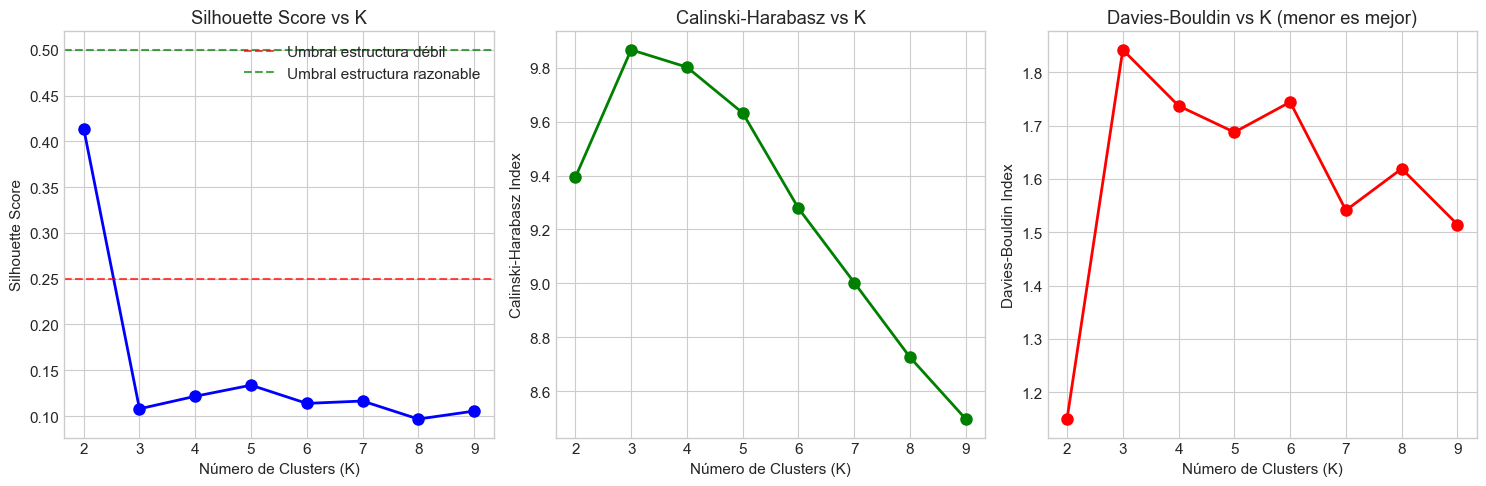

In [22]:
# Visualización de métricas
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Silhouette
axes[0].plot(
    df_results["K"], df_results["Silhouette"], "bo-", linewidth=2, markersize=8
)
axes[0].axhline(
    y=0.25, color="r", linestyle="--", alpha=0.7, label="Umbral estructura débil"
)
axes[0].axhline(
    y=0.50, color="g", linestyle="--", alpha=0.7, label="Umbral estructura razonable"
)
axes[0].set_xlabel("Número de Clusters (K)")
axes[0].set_ylabel("Silhouette Score")
axes[0].set_title("Silhouette Score vs K")
axes[0].legend(loc="upper right")
axes[0].set_xticks(df_results["K"])

# Calinski-Harabasz
axes[1].plot(
    df_results["K"], df_results["Calinski-Harabasz"], "go-", linewidth=2, markersize=8
)
axes[1].set_xlabel("Número de Clusters (K)")
axes[1].set_ylabel("Calinski-Harabasz Index")
axes[1].set_title("Calinski-Harabasz vs K")
axes[1].set_xticks(df_results["K"])

# Davies-Bouldin
axes[2].plot(
    df_results["K"], df_results["Davies-Bouldin"], "ro-", linewidth=2, markersize=8
)
axes[2].set_xlabel("Número de Clusters (K)")
axes[2].set_ylabel("Davies-Bouldin Index")
axes[2].set_title("Davies-Bouldin vs K (menor es mejor)")
axes[2].set_xticks(df_results["K"])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "validation_metrics.png", dpi=150, bbox_inches="tight")
plt.show()

## 4. Gap Statistic

El Gap statistic compara la dispersión dentro de clusters con la esperada bajo una distribución uniforme.
K óptimo es el menor K donde Gap(k) ≥ Gap(k+1) - s_{k+1}.

Gap statistic K óptimo: 1


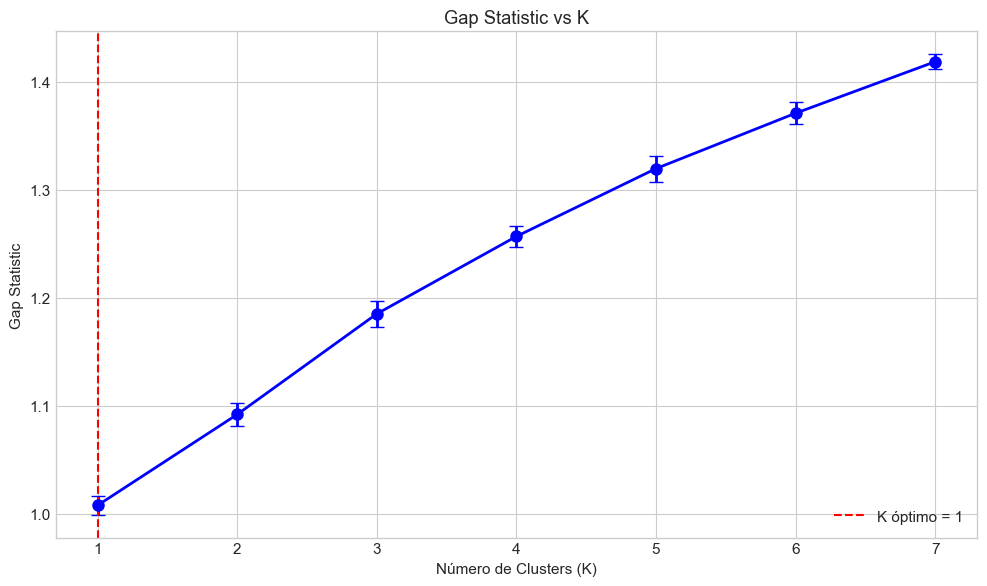

In [23]:
def gap_statistic(X, k_range, n_references=20):
    """Calcula Gap statistic."""
    np.random.seed(42)
    gaps = []
    sks = []

    for k in k_range:
        link = linkage(X, method="ward")
        clusters = fcluster(link, k, criterion="maxclust")

        # Within-cluster dispersion
        Wk = 0
        for c in range(1, k + 1):
            cluster_points = X[clusters == c]
            if len(cluster_points) > 1:
                Wk += np.sum(np.var(cluster_points, axis=0)) * len(cluster_points)

        # Reference datasets
        ref_Wks = []
        for _ in range(n_references):
            X_ref = np.random.uniform(X.min(axis=0), X.max(axis=0), X.shape)
            link_ref = linkage(X_ref, method="ward")
            clusters_ref = fcluster(link_ref, k, criterion="maxclust")

            Wk_ref = 0
            for c in range(1, k + 1):
                cluster_points = X_ref[clusters_ref == c]
                if len(cluster_points) > 1:
                    Wk_ref += np.sum(np.var(cluster_points, axis=0)) * len(
                        cluster_points
                    )
            ref_Wks.append(np.log(Wk_ref + 1e-10))

        gap = np.mean(ref_Wks) - np.log(Wk + 1e-10)
        sk = np.std(ref_Wks) * np.sqrt(1 + 1 / n_references)
        gaps.append(gap)
        sks.append(sk)

    return gaps, sks


k_range = list(range(1, 8))
gaps, sks = gap_statistic(X, k_range, n_references=30)

# Determinar K óptimo
optimal_k = 1
for i in range(len(k_range) - 1):
    if gaps[i] >= gaps[i + 1] - sks[i + 1]:
        optimal_k = k_range[i]
        break

print(f"Gap statistic K óptimo: {optimal_k}")

# Visualización
fig, ax = plt.subplots(figsize=(10, 6))
ax.errorbar(k_range, gaps, yerr=sks, fmt="bo-", linewidth=2, markersize=8, capsize=5)
ax.axvline(x=optimal_k, color="r", linestyle="--", label=f"K óptimo = {optimal_k}")
ax.set_xlabel("Número de Clusters (K)")
ax.set_ylabel("Gap Statistic")
ax.set_title("Gap Statistic vs K")
ax.legend()
ax.set_xticks(k_range)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "gap_statistic.png", dpi=150, bbox_inches="tight")
plt.show()

## 5. Permutation Test

Evaluamos si el mejor silhouette score (K=2) es significativamente mejor que lo esperado por azar.

In [24]:
# Silhouette real con K=2
clusters_2 = fcluster(linkage_matrix, 2, criterion="maxclust")
real_silhouette = silhouette_score(X, clusters_2)

# Permutation test
np.random.seed(42)
n_permutations = 500
random_silhouettes = []

for i in range(n_permutations):
    X_shuffled = X.copy()
    for col in range(X.shape[1]):
        np.random.shuffle(X_shuffled[:, col])
    linkage_rand = linkage(X_shuffled, method="ward")
    clusters_rand = fcluster(linkage_rand, 2, criterion="maxclust")
    random_silhouettes.append(silhouette_score(X_shuffled, clusters_rand))

p_value = np.mean([rs >= real_silhouette for rs in random_silhouettes])

print(f"Silhouette real (K=2): {real_silhouette:.4f}")
print(
    f"Silhouette aleatorio: {np.mean(random_silhouettes):.4f} ± {np.std(random_silhouettes):.4f}"
)
print(f"p-value: {p_value:.4f}")
print(f"Significativo (p < 0.05): {'SÍ' if p_value < 0.05 else 'NO'}")

Silhouette real (K=2): 0.4140
Silhouette aleatorio: 0.0881 ± 0.0737
p-value: 0.0000
Significativo (p < 0.05): SÍ


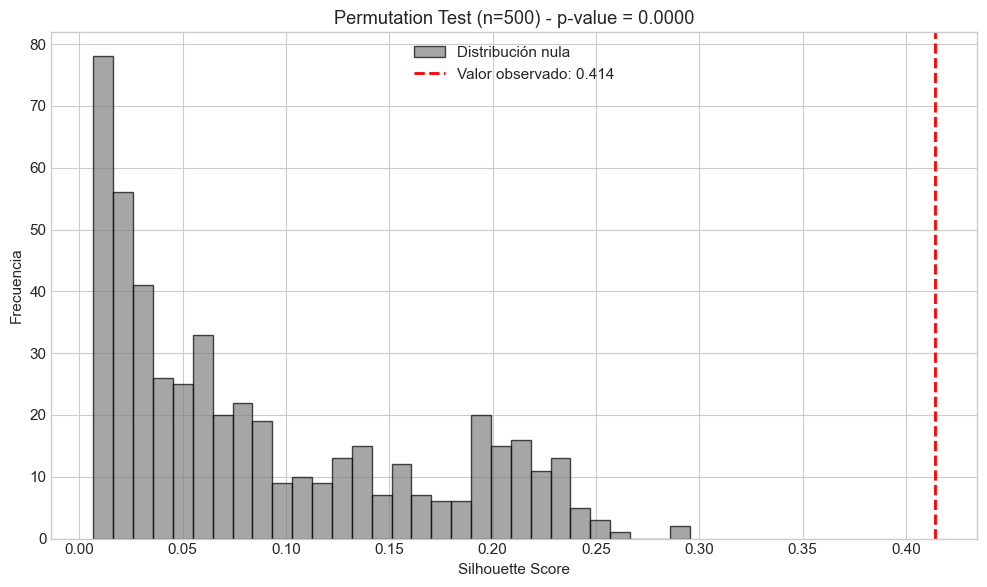

In [25]:
# Visualización del permutation test
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(
    random_silhouettes,
    bins=30,
    alpha=0.7,
    color="gray",
    edgecolor="black",
    label="Distribución nula",
)
ax.axvline(
    x=real_silhouette,
    color="red",
    linewidth=2,
    linestyle="--",
    label=f"Valor observado: {real_silhouette:.3f}",
)
ax.set_xlabel("Silhouette Score")
ax.set_ylabel("Frecuencia")
ax.set_title(f"Permutation Test (n={n_permutations}) - p-value = {p_value:.4f}")
ax.legend()
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "permutation_test.png", dpi=150, bbox_inches="tight")
plt.show()

## 6. Análisis de K=2

In [26]:
# Distribución de clusters con K=2
print("Distribución de sujetos con K=2:")
cluster_counts = np.bincount(clusters_2)[1:]
for i, count in enumerate(cluster_counts, 1):
    print(f"  Cluster {i}: {count} sujetos ({100*count/len(clusters_2):.1f}%)")

# Silhouette por cluster
sil_samples = silhouette_samples(X, clusters_2)
print("\nSilhouette por cluster:")
for c in [1, 2]:
    mask = clusters_2 == c
    print(
        f"  Cluster {c}: mean={sil_samples[mask].mean():.3f}, std={sil_samples[mask].std():.3f}"
    )

Distribución de sujetos con K=2:
  Cluster 1: 3 sujetos (3.8%)
  Cluster 2: 75 sujetos (96.2%)

Silhouette por cluster:
  Cluster 1: mean=0.140, std=0.089
  Cluster 2: mean=0.425, std=0.098


## 7. Visualización t-SNE

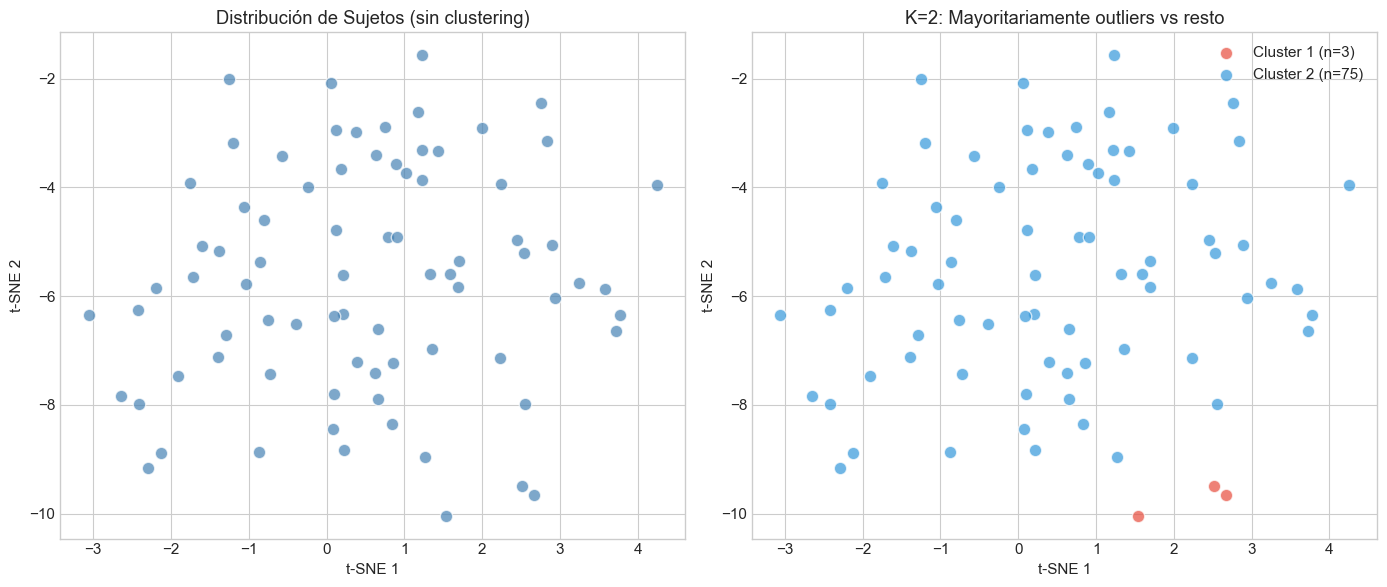

In [27]:
# t-SNE para visualización
tsne = TSNE(
    n_components=2, random_state=42, perplexity=min(30, len(X) - 1), max_iter=1000
)
X_tsne = tsne.fit_transform(X)

# Plot sin clusters (mostrando el continuo)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sin colores de cluster
axes[0].scatter(
    X_tsne[:, 0], X_tsne[:, 1], c="steelblue", s=80, alpha=0.7, edgecolors="white"
)
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")
axes[0].set_title("Distribución de Sujetos (sin clustering)")

# Con K=2 para mostrar el problema
colors = ["#E74C3C", "#3498DB"]
for i, cluster in enumerate([1, 2]):
    mask = clusters_2 == cluster
    axes[1].scatter(
        X_tsne[mask, 0],
        X_tsne[mask, 1],
        c=colors[i],
        label=f"Cluster {cluster} (n={mask.sum()})",
        s=80,
        alpha=0.7,
        edgecolors="white",
    )
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
axes[1].set_title("K=2: Mayoritariamente outliers vs resto")
axes[1].legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "tsne_visualization.png", dpi=150, bbox_inches="tight")
plt.show()

## 8. Dendrograma

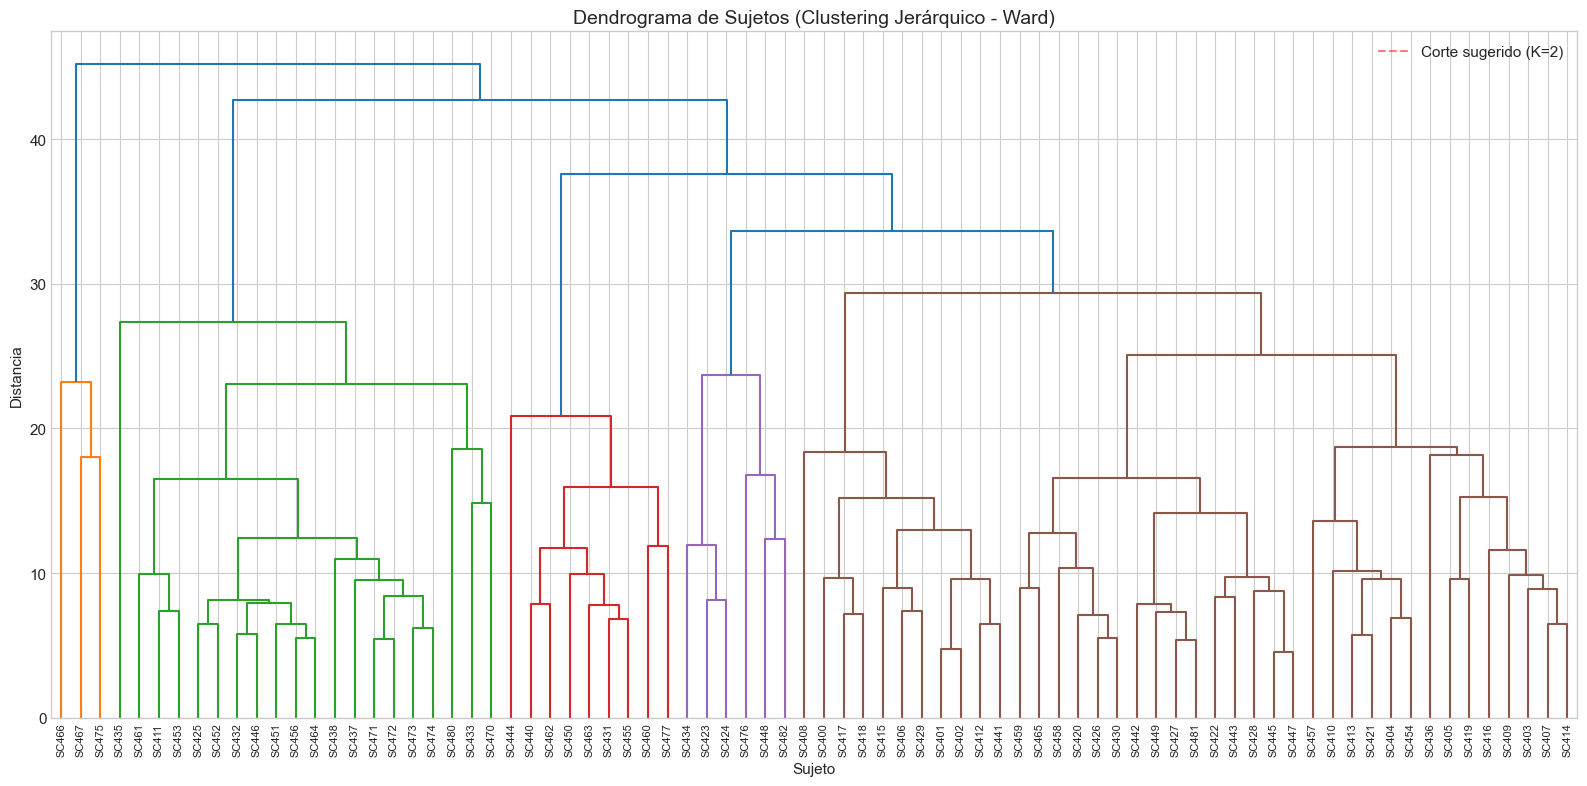

In [28]:
# Dendrograma
fig, ax = plt.subplots(figsize=(16, 8))
dendrogram(
    linkage_matrix,
    labels=df_subject.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
    ax=ax,
)
ax.set_title("Dendrograma de Sujetos (Clustering Jerárquico - Ward)", fontsize=14)
ax.set_xlabel("Sujeto")
ax.set_ylabel("Distancia")
ax.axhline(y=100, color="r", linestyle="--", alpha=0.5, label="Corte sugerido (K=2)")
ax.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "dendrogram.png", dpi=150, bbox_inches="tight")
plt.show()

---

## 9. Conclusión

### Resumen de Métricas

In [29]:
print("=" * 70)
print("RESUMEN DEL ANÁLISIS DE CLUSTERING")
print("=" * 70)

print(f"""
DATOS:
  - Sujetos: {len(df_subject)}
  - Features: {len(feature_cols)}

MÉTRICAS DE VALIDACIÓN:
  - Hopkins statistic: {hopkins_mean:.3f} (tendencia {'moderada' if hopkins_mean > 0.5 else 'baja'} a clustering)
  - Silhouette K=2: {real_silhouette:.3f} (estructura débil, umbral > 0.50)
  - Silhouette K≥3: < 0.14 (sin estructura clara)
  - Gap statistic K óptimo: {optimal_k}
  - Permutation test p-value: {p_value:.4f}

PROBLEMA CON K=2:
  - Distribución: {cluster_counts[0]} vs {cluster_counts[1]} sujetos
  - Esto representa detección de outliers, no subpoblaciones
""")

RESUMEN DEL ANÁLISIS DE CLUSTERING

DATOS:
  - Sujetos: 78
  - Features: 133

MÉTRICAS DE VALIDACIÓN:
  - Hopkins statistic: 0.749 (tendencia moderada a clustering)
  - Silhouette K=2: 0.414 (estructura débil, umbral > 0.50)
  - Silhouette K≥3: < 0.14 (sin estructura clara)
  - Gap statistic K óptimo: 1
  - Permutation test p-value: 0.0000

PROBLEMA CON K=2:
  - Distribución: 3 vs 75 sujetos
  - Esto representa detección de outliers, no subpoblaciones



In [30]:
# Conclusión final
print("=" * 70)
print("CONCLUSIÓN")
print("=" * 70)

conclusion = """
Se aplicó clustering jerárquico (Ward) a los 78 sujetos del dataset Sleep-EDF,
representados por 133 features promediadas.

HALLAZGOS:

1. El Gap statistic sugiere K=1 como óptimo, indicando ausencia de clusters
   naturales en los datos.

2. Aunque K=2 produce un silhouette score significativamente mayor que el
   esperado por azar (0.41, p<0.001), la distribución resultante (3 vs 75
   sujetos) representa detección de outliers más que identificación de
   subpoblaciones.

3. Para K≥3, el silhouette score cae a ~0.10-0.13, indicando ausencia de
   estructura de clustering significativa.

INTERPRETACIÓN:

Los sujetos del dataset Sleep-EDF forman un ESPECTRO CONTINUO en el espacio
de features, sin subgrupos discretos claramente identificables. La variabilidad
observada entre sujetos es gradual, no categórica.

Esto es consistente con la literatura de medicina del sueño, donde las
diferencias individuales en arquitectura del sueño típicamente varían de
forma continua en la población general (no clínica).
"""

print(conclusion)

# Guardar conclusión
with open(OUTPUT_DIR / "conclusion.txt", "w") as f:
    f.write(conclusion)

CONCLUSIÓN

Se aplicó clustering jerárquico (Ward) a los 78 sujetos del dataset Sleep-EDF,
representados por 133 features promediadas.

HALLAZGOS:

1. El Gap statistic sugiere K=1 como óptimo, indicando ausencia de clusters
   naturales en los datos.

2. Aunque K=2 produce un silhouette score significativamente mayor que el
   esperado por azar (0.41, p<0.001), la distribución resultante (3 vs 75
   sujetos) representa detección de outliers más que identificación de
   subpoblaciones.

3. Para K≥3, el silhouette score cae a ~0.10-0.13, indicando ausencia de
   estructura de clustering significativa.

INTERPRETACIÓN:

Los sujetos del dataset Sleep-EDF forman un ESPECTRO CONTINUO en el espacio
de features, sin subgrupos discretos claramente identificables. La variabilidad
observada entre sujetos es gradual, no categórica.

Esto es consistente con la literatura de medicina del sueño, donde las
diferencias individuales en arquitectura del sueño típicamente varían de
forma continua en la po

In [31]:
# Guardar resultados
df_results.to_csv(OUTPUT_DIR / "validation_metrics.csv", index=False)

summary = {
    "n_subjects": int(len(df_subject)),
    "n_features": int(len(feature_cols)),
    "hopkins_statistic": float(hopkins_mean),
    "gap_optimal_k": int(optimal_k),
    "silhouette_k2": float(real_silhouette),
    "permutation_pvalue": float(p_value),
    "cluster_distribution_k2": [int(x) for x in cluster_counts],
    "conclusion": "No se identificaron subpoblaciones discretas. Los sujetos forman un espectro continuo.",
}

with open(OUTPUT_DIR / "analysis_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print(f"\nResultados guardados en: {OUTPUT_DIR}")
print("  - validation_metrics.csv")
print("  - validation_metrics.png")
print("  - gap_statistic.png")
print("  - permutation_test.png")
print("  - tsne_visualization.png")
print("  - dendrogram.png")
print("  - analysis_summary.json")
print("  - conclusion.txt")


Resultados guardados en: /Users/ignacio/Repos/sleep-ST/reports/clustering
  - validation_metrics.csv
  - validation_metrics.png
  - gap_statistic.png
  - permutation_test.png
  - tsne_visualization.png
  - dendrogram.png
  - analysis_summary.json
  - conclusion.txt


---

## 10. Conclusiones Finales

### Resumen de Métricas de Validación

| Métrica | Valor | Interpretación |
|---------|-------|----------------|
| **Hopkins statistic** | 0.749 | Tendencia moderada a clustering |
| **Gap statistic K óptimo** | 1 | No hay clusters naturales |
| **Silhouette K=2** | 0.414 | Estructura débil (umbral >0.50) |
| **Silhouette K≥3** | <0.14 | Sin estructura clara |
| **Permutation test** | p<0.001 | K=2 es significativo vs aleatorio |
| **Distribución K=2** | 3 vs 75 | Outliers, no subpoblaciones |

### Análisis de los 3 Sujetos Atípicos

Los 3 sujetos que forman el "cluster" minoritario en K=2 son **SC466, SC467 y SC475**.

**Pregunta**: ¿Son sujetos con una sola noche de grabación?  
**Respuesta**: **NO**. Los 3 tienen 2 sesiones grabadas, igual que la mayoría.

**Característica distintiva**: Sueño fragmentado

| Sujeto | Sesiones | Wake | N1 | N2 | N3 | REM |
|--------|----------|------|-----|-----|-----|-----|
| SC466 | 2 | **50.7%** | 15.6% | 21.4% | 3.0% | 9.2% |
| SC467 | 2 | **40.6%** | 19.8% | 29.5% | 1.6% | 8.5% |
| SC475 | 2 | **57.0%** | 8.2% | 30.2% | 0.7% | 4.0% |
| **Promedio resto** | - | 25.6% | 11.4% | 40.1% | 8.0% | 14.9% |

Estos sujetos presentan:
- **~50% de tiempo en Wake** (vs 26% promedio) - mucha vigilia intrasueño
- **~2% de N3** (vs 8% promedio) - casi sin sueño profundo
- **~7% de REM** (vs 15% promedio) - poco sueño REM

Posibles explicaciones: grabaciones de mala calidad, sujetos con insomnio subclínico, o simplemente malas noches de sueño.

### Conclusión Científica

> **Los 78 sujetos del dataset Sleep-EDF forman un espectro continuo en el espacio de features, sin subpoblaciones discretas claramente identificables.**

El análisis de clustering con múltiples métricas de validación (Gap statistic, Silhouette, Hopkins, permutation test) indica que:

1. **No existen clusters naturales** en los datos (Gap statistic K óptimo = 1)

2. **La división K=2** produce un silhouette significativo (0.41, p<0.001), pero la distribución 3/75 representa **detección de outliers**, no identificación de subpoblaciones

3. **Los 3 outliers** (SC466, SC467, SC475) se caracterizan por sueño fragmentado (~50% Wake, ~2% N3), ubicándose en un extremo del espectro continuo

4. **La variabilidad es gradual, no categórica**, consistente con la literatura de medicina del sueño donde las diferencias individuales en arquitectura del sueño varían continuamente en poblaciones no clínicas

### Implicaciones para el Modelo de Clasificación

Este hallazgo explica parcialmente por qué el modelo XGBoost tiene performance similar (Kappa ~0.64-0.68) independientemente del perfil de sueño del sujeto: **no hay subgrupos con características fundamentalmente diferentes** que requieran estrategias de modelado distintas.

La validación LOSO es apropiada dado que los sujetos representan un continuo, no grupos discretos que podrían requerir estratificación.